# Optimize distance : forecasting of tropical cylone data as a function of horizon

This notebook accompanies the following publication:
Paul Platzer, Arthur Avenas, Bertrand Chapron, Lucas Drumetz, Alexis Mouche, Léo Vinour. Distance Learning for Analog Methods. 2024. [⟨hal-04841334⟩](https://hal.science/hal-04841334)

It is used to plot the result of optimization algorithms for numerical experiments with IBTrACS tropical cyclone data, varying the forecast horizon.

In [7]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm
from sklearn.neighbors import KDTree
import os
import sys
sys.path.append('../../functions/.')
from distance_learning import CRPS_TC
from TC_utils import M, Rmax_from_M, correct_vmx_ibt, Rmxa23

In [12]:
matplotlib.rcParams.update({'font.size': 14})
cols = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [3]:
data_folder = '../../data/tropical_cyclone/'
output_folder = '../../output/tropical_cyclone/'

# Parameters for loading IBTrACS dataset

In [4]:
files = os.listdir(data_folder)

# Input variables
var_names = ['Vmax', 'Rmax_IBT', 'R34', 'fcor', 'u_trans', 'v_trans']

# Output variable to forecast: derivative of Vmax
var_y = ['Vmax']
dydt = True
ind_var_y = []
for name_tmp in var_y:
    ind_var_y.append(np.argwhere(np.array(var_names)==name_tmp)[0][0])

# Utils to compute Rmax estimate from Avenas et al. (2023)
var_A23 = ['fcor', 'Vmax', 'R34', ]
ind_A23 = []
for name_tmp in var_A23:
    ind_A23.append(np.argwhere(np.array(var_names)==name_tmp)[0][0])

# Add names of auxilliary variables (Rmax_A23 and time-derivatives)
var_names_all = var_names.copy()
var_names_all.append('Rmax_A23')
for name in var_names_all.copy():
    var_names_all.append('d'+name+'/dt')

# Add name of time since the threshold of 18m/s is crossed for Vmax
var_names_all.append('t_18')

# Load optimization results

In [6]:
npzfile = np.load(output_folder + 'optim_TC_horizon.npz')
var_y = npzfile['var_y']
var_names_all = npzfile['var_names_all']
A = npzfile['A']
E_train = npzfile['E_train']
E_test = npzfile['E_test']
hh = npzfile['hh']
k = npzfile['k']
corr_length_train = npzfile['corr_length_train']
Nperm = A.shape[1]

# Also compute simple benchmarks
Climatology and persistence.

In [9]:
scale_dV = []
Kinit = []
Kcrps = []
Pcrps = []
Pinit = []
Finit = []
Fcrps = []
dYcrps = []
dYinit = []
Ecrps = []
Einit = []
MAE_per = []
CRPS_clim = []

# Loop on forecast horizon
for l in tqdm(range(len(hh))):

    h = hh[l]

    # Load IBTrACS dataset
    IBT = np.array(pandas.read_csv(data_folder + files[0], usecols = var_names))
    IBT = np.concatenate( [ IBT , 
             Rmxa23(IBT[:,ind_A23[0]] , IBT[:,ind_A23[1]] , IBT[:,ind_A23[2]]).reshape(-1,1) ,
                          ],  axis=1)
    IBT = np.concatenate( ( IBT[1:] , IBT[1:] - IBT[:-1] ) , axis=1 )
    IBT = np.concatenate( [ IBT ,
               3*np.arange(len(IBT)).reshape(-1,1) ],  axis=1)
    train_x = IBT[0:-h,:]
    train_y = IBT[h:,ind_var_y] - IBT[0:-h,ind_var_y] 
    ID = np.array([0]*len(IBT[0:-h,:]))
    

    for i in np.arange(1, len(files)):
        IBT = np.array(pandas.read_csv(data_folder + files[i], usecols = var_names))
        IBT = np.concatenate( [ IBT , 
                 Rmxa23(IBT[:,ind_A23[0]] , IBT[:,ind_A23[1]] , IBT[:,ind_A23[2]]).reshape(-1,1) ,
                              ],  axis=1)
        IBT = np.concatenate( ( IBT[1:] , IBT[1:] - IBT[:-1] ) , axis=1 )
        IBT = np.concatenate( [ IBT ,
               3*np.arange(len(IBT)).reshape(-1,1) ],  axis=1)
        train_x = np.concatenate([train_x, IBT[0:-h,:]])
        train_y = np.concatenate([train_y, IBT[h:,ind_var_y] - IBT[0:-h,ind_var_y]])
        ID = np.concatenate([ID, np.array([i]*len(IBT[0:-h,:]))])

    # Center and reduce
    mean_IBTrACS = np.mean(train_x, axis=0)
    std_IBTrACS = np.std(train_x, axis=0)
    mean_y = np.mean(train_y, axis=0)
    std_y = np.std(train_y, axis=0)
    for j in range(train_x.shape[1]):
        train_x[:,j] = (train_x[:,j] - mean_IBTrACS[j]) / std_IBTrACS[j]
    for j in range(train_y.shape[1]):
        train_y[:,j] = (train_y[:,j] - mean_y[j]) / std_y[j]
        
    scale_dV.append( std_y )
    
    
    # Compute CRPS with optimized distance
    Ecrps_perm = []
    for j in tqdm(range(Nperm)):
        Ecrps_perm.append( CRPS_TC(train_x, train_y, train_x, train_y, 
              np.array(A)[l,j,-1], k, loo=True, corr_length_train=corr_length_train) )
    Ecrps.append( np.array(Ecrps_perm) )
    
    # Compute CRPS with unoptimized distance
    Einit.append( CRPS_TC(train_x, train_y, train_x, train_y, 
              np.ones(len(var_names_all)), k, loo=True, corr_length_train=corr_length_train) )
    
    # Compare with persistence forecast (for which the CRPS equals the Mean Absolute Error MAE)
    MAE_per.append( np.mean(np.abs(train_y)) )
    
    # Compare with CRPS of climatological prediction
    subsamp2 = 10 # subsampling parameter to make computation faster
    crps_clim_pred = .5*np.mean(
        np.abs( np.repeat(train_y[::subsamp2, np.newaxis], len(train_y[::subsamp2]), axis=1)
           - np.transpose( np.repeat(train_y[::subsamp2, np.newaxis], len(train_y[::subsamp2]), axis=1) ) ) 
    )
    CRPS_clim.append(crps_clim_pred.copy())
    
scale_dV = np.array(scale_dV)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

# Plots

In [10]:
gain_train = 100*( E_train[:,:,0] - E_train[:,:,-1] ) / E_train[:,:,0]
gain_test = 100*( E_test[:,:,0] - E_test[:,:,-1] ) / E_test[:,:,0]

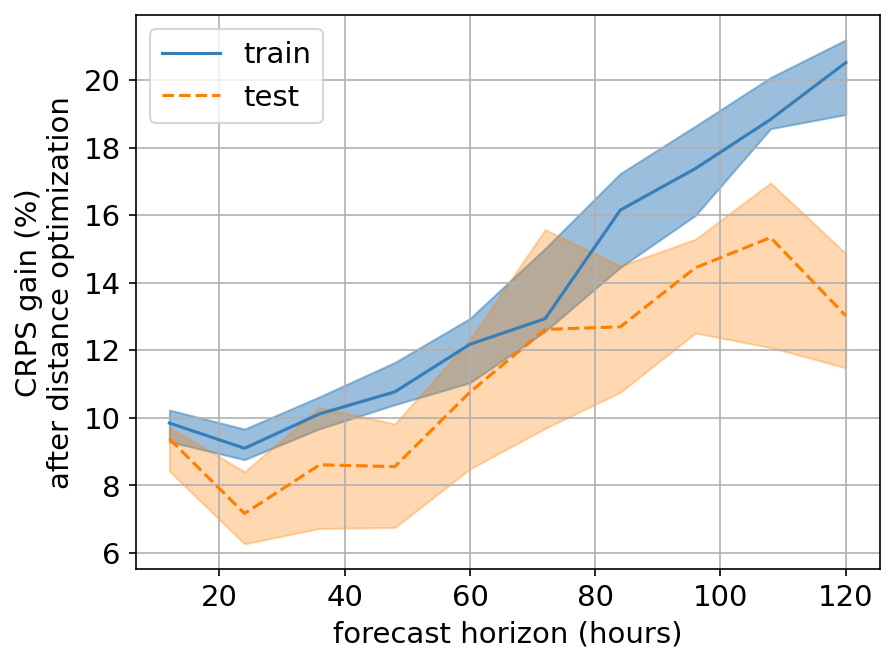

In [13]:
plt.figure(dpi=150)
plt.fill_between(hh*3, np.quantile(gain_train, q=.25, axis=1),
                  np.quantile(gain_train, q=.75, axis=1), color=cols[0], alpha=.5)
plt.plot(hh*3, np.median(gain_train,axis=1), '-', color=cols[0], label='train')
plt.fill_between(hh*3, np.quantile(gain_test, q=.25, axis=1),
                  np.quantile(gain_test, q=.75, axis=1), color=cols[1], alpha=.3)
plt.plot(hh*3, np.median(gain_test, axis=1), '--', color=cols[1], label='test')
plt.ylabel('CRPS gain (%)\nafter distance optimization')
plt.xlabel('forecast horizon (hours)')
plt.legend(); plt.grid()
plt.show()

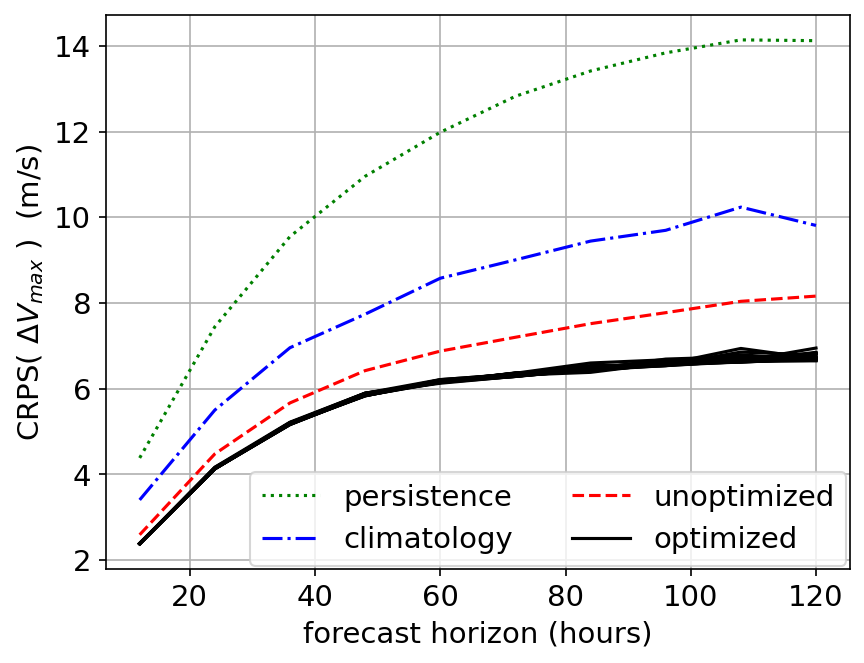

In [14]:
plt.figure(dpi=150)
plt.plot(np.array(hh)*3, np.array(hh)**0 * MAE_per * scale_dV[:,0], ':g', label=r'persistence')# $\Delta V_{max} = 0$')
plt.plot(np.array(hh)*3, np.array(hh)**0 * CRPS_clim * scale_dV[:,0], '-.b', label=r'climatology')# of $\Delta V_{max}$')
plt.plot(np.array(hh)*3, np.array(Einit)*scale_dV[:,0], '--r', label='unoptimized')
for j in range(Nperm):
    plt.plot(np.array(hh)*3, np.array(Ecrps)[:,j]*scale_dV[:,0], '-k', label='optimized'*(j==0))
# plt.legend(bbox_to_anchor = (1.02,0), loc = 3)
plt.legend(bbox_to_anchor = (1.015,-0.02), loc = 4, ncol=2)
plt.ylabel(r'CRPS( $\Delta V_{max}$ )  (m/s)')
plt.xlabel('forecast horizon (hours)')
plt.grid()
plt.show()